In [4]:
import socket
import struct
from time import sleep
import time
import unicodedata

# from oei import *
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np
import warnings
import time


In [5]:
"""

"""



class OEI(object):

    def __init__(self,ipaddr,port=2001):
        self.sock = socket.socket(socket.AF_INET,socket.SOCK_DGRAM)
        self.target = (ipaddr,port)

    def read_reg(self,addr,size): 
        cmd = struct.pack("BB",0x00,size) 
        cmd += struct.pack("Q",addr)
        self.sock.sendto(cmd,self.target)
        d,a = self.sock.recvfrom(2+(8*size))
        return struct.unpack(f"<BB{size}Q",d) 

    def write_reg(self,addr,data): 
        cmd = struct.pack("BB",1,len(data)) 
        cmd += struct.pack("Q",addr)
        for i in data:
            cmd += struct.pack("Q",i)
        self.sock.sendto(cmd,self.target)

    def read_fifo(self,addr,size):
        cmd = struct.pack("BB",0x08,size) 
        cmd += struct.pack("Q",addr)
        self.sock.sendto(cmd,self.target)
        d,a = self.sock.recvfrom(2+(8*size))
        return struct.unpack(f"<BB{size}Q",d)

    def write_fifo(self,addr,data): 
        cmd = struct.pack("BB",0x09,len(data)) 
        cmd += struct.pack("Q",addr)
        for i in data:
            cmd += struct.pack("Q",i)
        self.sock.sendto(cmd,self.target)

    def close(self):
        self.sock.close()


In [3]:

def remove_control_characters(s):
    return "".join(ch for ch in s if unicodedata.category(ch)[0]!="C")
    
class Command:
    def __init__(self,ip, cmd_string, get_response=True):
        self.device = OEI(ip)
        self.cmd_bytes = [ord(ch) for ch in cmd_string]
        self.cmd_bytes.append(0x0d)
        for i in range(0, len(self.cmd_bytes), 50):
            self.device.write_fifo(0x90000000, self.cmd_bytes[i*50:(i+1)*50])
        self.response = self.get_response_data() if get_response else None
        self.device.close()
        
    def get_response_data(self):
        response = ""
        self.more = 40
        while self.more > 0:
            response_bytes = self.device.read_fifo(0x90000000,50) 
            for b in response_bytes[2:]:
                if b == 255:
                    break
                elif b in (1, 2, 3):
                    response += f"[{['START', 'RESULT', 'END'][b-1]}]"
                elif chr(b).isprintable:
                    self.more = 40
                    response = response + chr(b)
            sleep(0.007)
            self.more -= 1
        response = response + chr(0)
        print(response)
        return remove_control_characters(response)
        
# read_bias=[Command(f'10.73.137.{100+i}', 'RD VM ALL') for i in [4,5,7,9,11,12,13]]


[START]WR AFE 0 REG 51 V 0[RESULT]Executing command 8 ... CMD Write AFE0 REG51 success
 ... Command Complete, return code 0
[END] 


Reading from endpoint 104::   0%|          | 0/1000 [00:00<?, ?waveforms/s]

[START]WR AFE 0 REG 51 V 3[RESULT]Executing command 8 ... CMD Write AFE0 REG51 success
 ... Command Complete, return code 0
[END] 


Reading from endpoint 104::   0%|          | 0/1000 [00:00<?, ?waveforms/s]

[START]WR AFE 0 REG 51 V 2[RESULT]Executing command 8 ... CMD Write AFE0 REG51 success
 ... Command Complete, return code 0
[END] 


Reading from endpoint 104::   0%|          | 0/1000 [00:00<?, ?waveforms/s]

[START]WR AFE 0 REG 51 V 4[RESULT]Executing command 8 ... CMD Write AFE0 REG51 success
 ... Command Complete, return code 0
[END] 


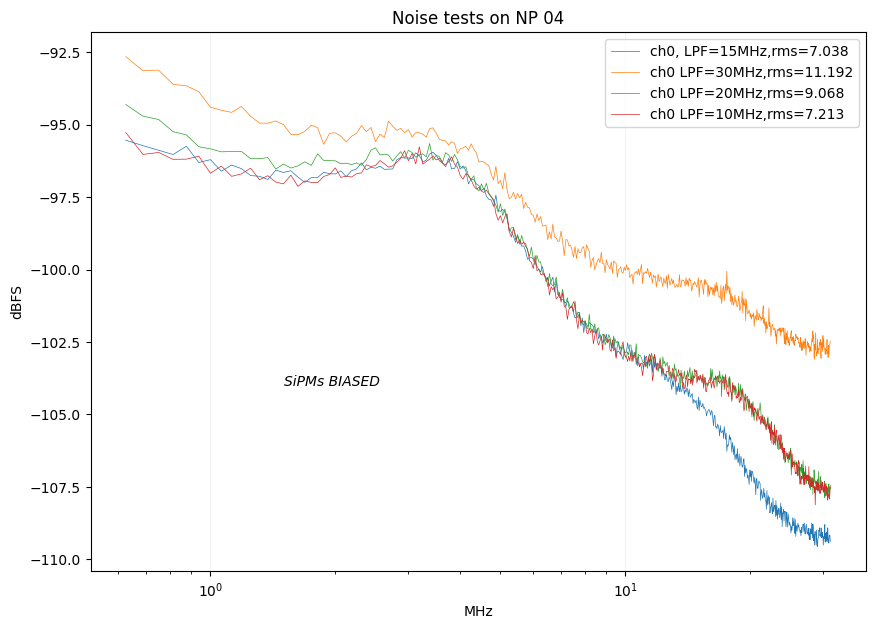

In [70]:


class readwave:
    def __init__(self, ep=112, afe=4, ch=4,plot=False):
        thing = OEI(f"10.73.137.{ep}")
        thing.write_reg(0x2000,[1234])
        wf=[]
        for i in range (20):
            doutrec = thing.read_reg(0x40000000+(0x100000 * afe)+(0x10000 * ch)+i*50,50)[2:]
            for word in doutrec:
                wf.append(word)
        x = np.linspace(0.0, len(wf) * 16e-9, num=len(wf))
        if plot:
            plt.figure()
            plt.plot(x,wf,linewidth=0.6,label=f' \t rms={np.round(np.mean(wf),2)}')
            plt.show()
        self.wf=np.array(wf)
        self.afe=afe
        self.ch=ch
        self.ep=ep
        thing.close()
class fft:
    def __init__(self, sig, dt=16e-9, plot=False):
        np.seterr(divide = 'ignore')
        if dt is None:
            dt = 1
            t = np.arange(0, sig.shape[-1])
            xLabel = "samples"
        else:
            t = np.arange(0, sig.shape[-1]) * dt
            xLabel = "freq [Hz]"
        if sig.shape[0] % 2 != 0:
            warnings.warn("signal preferred to be even in size, autoFixing it...")
            t = t[:-1]
            sig = sig[:-1]
        sigFFT = np.fft.fft(sig) / t.shape[0]
        freq = np.fft.fftfreq(t.shape[0], d=dt)
        firstNegInd = np.argmax(freq < 0)
        freqAxisPos = freq[:firstNegInd]
        sigFFTPos = 2 * sigFFT[:firstNegInd]
        if plot:
            plt.figure()
            plt.plot(freqAxisPos, 20*np.log10(np.abs(sigFFTPos)/2**14))
            plt.ylim([-140, -80])
            plt.xscale("log")
            plt.xlabel(xLabel)
            plt.ylabel("U.A.")
            plt.title("Analytic FFT plot")
            plt.show()
        self.x = freqAxisPos /10e5
        self.y = 20*np.log10(np.abs(sigFFTPos)/2**14)
#wf=readwave(plot=True).wf
#f=fft   (wf,dt=None,plot=True)    
class mean_fft:
    def __init__(self, data,label,plot=False):
        np.seterr(divide = 'ignore')
        fft_list_x=[]
        fft_list_y=[]
        mean_list=[]
        std_list=[]
        for k in range(len(data)):
            fft_list_x.append(fft(data[k]).x)
            fft_list_y.append(fft(data[k]).y)
            std_list.append(np.std(data[k],axis=0))
        self.x=np.mean(fft_list_x,axis=0)
        self.y=np.mean(fft_list_y,axis=0)
        self.stdx=np.round(np.mean(std_list,axis=0),3)
        if plot:
            plt.rcParams["figure.figsize"] = (10,7)
            plt.figure()
            plt.plot(self.x,self.y,linewidth=1,label=f'{label} \t rms={np.round(self.stdx,2)}'.expandtabs())
            plt.ylim([min(self.y)-10, -80])
            #plt.xscale("log")
            # plt.xlim([0.2, 3])
            plt.legend()
            plt.ylabel("dBFS")
            plt.xlabel("MHz")
            plt.title("FFT")
            plt.tight_layout()
def main():
    np.seterr(divide = 'ignore')
    plt.rcParams["figure.figsize"] = (10,7)
    plt.figure()
    AFE=[0]
    ammount=1000
    ep=112
    # thing = OEI(f"10.73.137.{100+ep}")
    
    for j in [ep]:
        
        for k in AFE:
            Command(f'10.73.137.{ep}',f'WR AFE {k} REG 51 V 0')
            for l in range(1):
                progress=trange(ammount, unit='waveforms',desc = f'Reading from endpoint {j}:')
                d = [readwave(ep=j, ch=l,afe=AFE[k]).wf for _ in range(ammount) ]
                mfft=mean_fft(d,label=f'endpoint {j}')
                plt.plot(mfft.x[10:],mfft.y[10:],linewidth=0.5,label=f'ch{l}, LPF=15MHz,rms={mfft.stdx}'.expandtabs())
    
    # thing.command('WR AFE '+ str(int(AFE)) + ' REG 52 V 16896')
    # thing.command('WR AFE '+ str(int(AFE)) + ' REG 4 V 24')
    # Command(f'10.73.137.{ep}',f'WR AFE {k} REG 51 V 3')
    # thing.command('WR AFE '+ str(int(AFE)) + ' VGAIN V 2318')
    # for j in [ep]:
    #     for k in AFE:
    #         for l in range(1):
    #             progress=trange(ammount, unit='waveforms',desc = f'Reading from endpoint {j}:')
    #             d = [readwave(ep=j, ch=l,afe=AFE[k]).wf for _ in range(ammount) ]
    #             mfft=mean_fft(d,label=f'endpoint {j}')
    #             plt.plot(mfft.x[10:],mfft.y[10:],linewidth=0.5,label=f'ch{l} LPF=30MHz,rms={mfft.stdx}'.expandtabs())
    
    # thing.command('WR AFE '+ str(int(AFE)) + ' REG 52 V 16896')
    # thing.command('WR AFE '+ str(int(AFE)) + ' REG 4 V 24')
    # Command(f'10.73.137.{ep}',f'WR AFE {k} REG 51 V 2')
    # thing.command('WR AFE '+ str(int(AFE)) + ' VGAIN V 2318')
    # for j in [ep]:
    #     for k in AFE:
    #         for l in range(1):
    #             progress=trange(ammount, unit='waveforms',desc = f'Reading from endpoint {j}:')
    #             d = [readwave(ep=j, ch=l,afe=AFE[k]).wf for _ in range(ammount) ]
    #             mfft=mean_fft(d,label=f'endpoint {j}')
    #             plt.plot(mfft.x[10:],mfft.y[10:],linewidth=0.5,label=f'ch{l} LPF=20MHz,rms={mfft.stdx}'.expandtabs())
    
    # thing.command('WR AFE '+ str(int(AFE)) + ' REG 52 V 16896')
    # thing.command('WR AFE '+ str(int(AFE)) + ' REG 4 V 24')
    # Command(f'10.73.137.{ep}',f'WR AFE {k} REG 51 V 4')
    # thing.command('WR AFE '+ str(int(AFE)) + ' VGAIN V 2318')
    # for j in [ep]:
    #     for k in AFE:
    #         for l in range(1):
    #             # progress=trange(ammount, unit='waveforms',desc = f'Reading from endpoint {j}:')
    #             d = [readwave(ep=j, ch=l,afe=AFE[k]).wf for _ in range(ammount) ]
    #             mfft=mean_fft(d,label=f'endpoint {j}')
    #             plt.plot(mfft.x[10:],mfft.y[10:],linewidth=0.5,label=f'ch{l} LPF=10MHz,rms={mfft.stdx}'.expandtabs())
                
    # plt.axvline(x = 0.8125, color = 'b', label = '812.5kHz')
    # plt.axvline(x = 0.8125*2, color = 'r', label = '1625kHz')
    # plt.ylim([-120, -50])
    plt.xscale("log")
    #plt.xlim([0.8, 0.9])
    plt.legend(ncol=1)
    plt.ylabel("dBFS")
    plt.xlabel("MHz")
    #plt.title(f"Noise tests on APA 1 ch {Channel+AFE[0]*8} M7 disconnected, ch0 of M8 isolated")
    plt.title(f"Noise tests on NP 04")
    plt.grid(axis='x',color="0.95")
    # plt.text(1.5, -108, 'Integrators On', style='italic')
    # plt.text(1.5, -109, 'Offset=2200', style='italic')
    # plt.text(1.5, -110, 'VGAIN=2318', style='italic')
    plt.text(1.5, -104, 'SiPMs BIASED', style='italic')
    # plt.tight_layout()
    # plt.savefig(f'Noise tests ch{Channel+AFE*8}.png',dpi=400)
if __name__ == "__main__":
    main()

